In [ ]:
!wget https://www.dropbox.com/s/pl5nndeaawiv89s/with_mask-20220922T113758Z-001.zip?dl=0 https://www.dropbox.com/s/su9vmx9xf6nmon2/without_mask-20220922T113814Z-001.zip?dl=0

--2022-09-25 10:48:49--  https://www.dropbox.com/s/pl5nndeaawiv89s/with_mask-20220922T113758Z-001.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/pl5nndeaawiv89s/with_mask-20220922T113758Z-001.zip [following]
--2022-09-25 10:48:49--  https://www.dropbox.com/s/raw/pl5nndeaawiv89s/with_mask-20220922T113758Z-001.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucebb5d5eb1e24f0c16104563aed.dl.dropboxusercontent.com/cd/0/inline/BtlH1hxzUdJCl2TrcIDRm2hVUzVksKpgon8ObbEjaYvGTAaSvc6UPR5uXUcRpm7EwoLak5TERewVRauyBxMQRRjpc8GN1cvlGMOdAZMsZHJ-jB2gjjSnOFKkj9hsYzaY1Wah0gGj3fhGI_edB53bK3XSvRoNfboGdoL9AwVUxfhQSw/file# [following]
--2022-09-25 10:48:49--  https://ucebb5d5eb1e24f0c16104563aed.dl.dropboxusercontent.com/cd/0/inline/BtlH1hxzU

In [ ]:
with_mask=!unzip with_mask-20220922T113758Z-001.zip?dl=0
without_mask=!unzip without_mask-20220922T113814Z-001.zip?dl=0
!rm with_mask-20220922T113758Z-001.zip?dl=0
!rm without_mask-20220922T113814Z-001.zip?dl=0

## Import Required Libraries

In [ ]:
import numpy as np
import os
import shutil
import random
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,Dropout,MaxPooling2D,Activation,BatchNormalization,MaxPool2D,GlobalMaxPooling2D
from keras import regularizers
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.metrics import classification_report
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as k
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.image as mpimg

import json
from keras.models import model_from_json
from keras.models import load_model




## Load and Preprocess the dataset

In [ ]:
!mkdir train
!mkdir test
os.mkdir('/content/train/training_with_mask')
os.mkdir('/content/train/training_without_mask')
os.mkdir('/content/test/test_with_mask')
os.mkdir('/content/test/test_without_mask')

In [ ]:
def train_test_split(source, trainPath, testPath, split_size):
    dataset = []
    for crnImage in os.listdir(source):
        data = source + '/' + crnImage
        if(os.path.getsize(data) > 0):
            dataset.append(crnImage)
    train_len = int(len(dataset) * split_size)
    test_len = int(len(dataset) - train_len)
    shuffled = random.sample(dataset, len(dataset))
    train = dataset[0:train_len]
    test = dataset[train_len:len(dataset)]
    print("train images :",len(train))
    print("test images :",len(test))
  
    for trainDataPoint in train: 
        if trainDataPoint.endswith("jpg"):
          crnTrainDataPath = source + '/' + trainDataPoint
          newTrainDataPath =  trainPath + '/' + trainDataPoint
          shutil.copyfile(crnTrainDataPath, newTrainDataPath)
   
    for testDataPoint in test:
        if testDataPoint.endswith("jpg"):
          crnTestDataPath = source + '/' + testDataPoint
          newTestDataPath =  testPath + '/' + testDataPoint
          shutil.copyfile(crnTestDataPath, newTestDataPath)

## train-test-split

In [ ]:
train_test_split('/content/with_mask', '/content/train/training_with_mask', '/content/test/test_with_mask',0.8)
train_test_split('/content/without_mask','/content/train/training_without_mask', '/content/test/test_without_mask',0.8)

train images : 552
test images : 138
train images : 548
test images : 138


In [ ]:
import tensorflow.keras.backend as k
if k.image_data_format()=='channels_first': 
    input_shape=(3, 160, 160)
else:
    input_shape=(160,160,3)

## Encode the categorical data

In [ ]:

  training_dir = "/content/train"
  train_datagen = ImageDataGenerator(rescale=1.0/255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  train_generator = train_datagen.flow_from_directory(training_dir, 
                                                      batch_size=100, 
                                                      target_size=(160, 160),class_mode='binary',classes=['training_with_mask', 'training_without_mask'])
  validation_dir = "/content/test"
  validation_datagen = ImageDataGenerator(rescale=1.0/255)
  validation_generator = validation_datagen.flow_from_directory(validation_dir, 
                                                           batch_size=30, 
                                                           target_size=(160, 160),class_mode='binary',classes=['test_with_mask', 'test_without_mask'])
 


Found 1100 images belonging to 2 classes.
Found 276 images belonging to 2 classes.


## Visualize the Images


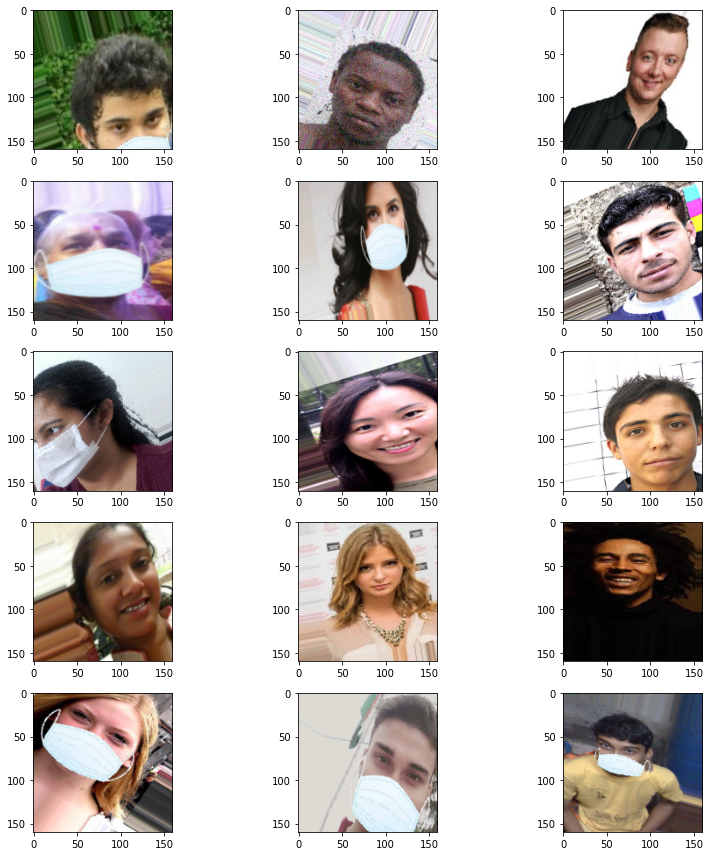

In [ ]:

plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in train_generator:
        #print(X_batch.shape)
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

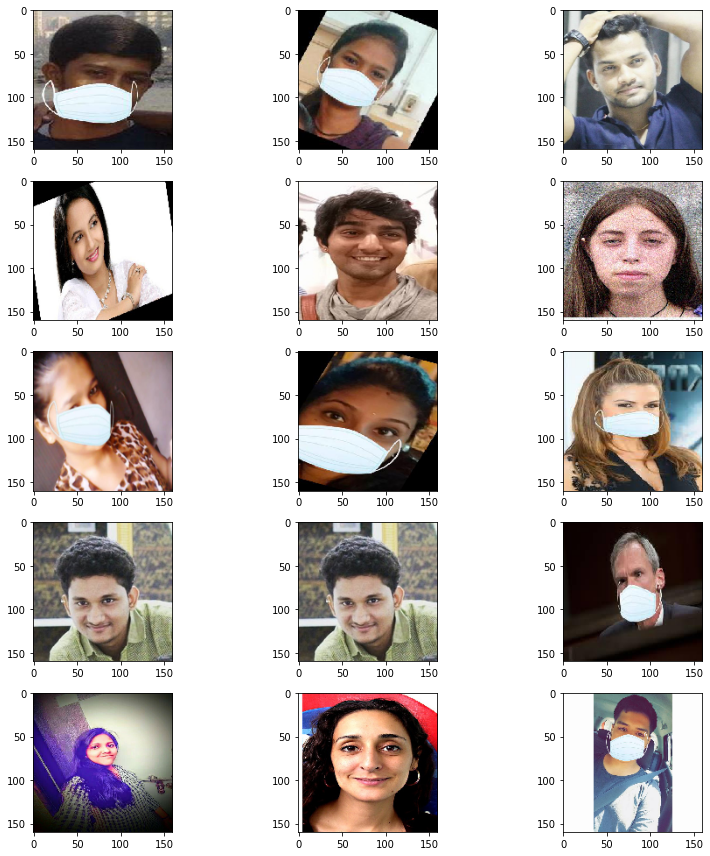

In [ ]:

plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in validation_generator:
        #print(X_batch.shape)
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## Basic Model

In [ ]:
model = Sequential()
model.add(Conv2D(64,(3,3),input_shape=input_shape)) #64 neurons with 3*3 filter
#This class allows to create convolutional neural network to extract feature from the images

model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))#MaxPooling2D helps to reduce the size of the data

model.add(Flatten())#Converts multi dimensional array to 1D channel
model.add(Dense(64)) #64 neurons with 3*3 filter 
#Numbers of output nodes in the hidden layer
model.add(Activation('relu'))
model.add(Dense(1)) #output layer
model.add(Activation('sigmoid')) #sigmoid activation function
model.summary()

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 158, 158, 64)      1792      
                                                                 
 activation (Activation)     (None, 158, 158, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 79, 79, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 399424)            0         
                                                                 
 dense (Dense)               (None, 64)                25563200  
                                                                 
 activation_1 (Activation)   (None, 64)                0         
                                                        

In [ ]:
training = model.fit_generator(train_generator,
                   #steps_per_epoch=nb_train_sample,
                   epochs=30,
                   validation_data=validation_generator,
                       #validation_steps=nb_validation_samples
                       )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/30
11/11 [==============================] - 44s 4s/step - loss: 7.4843 - accuracy: 0.5309 - val_loss: 1.7353 - val_accuracy: 0.5145
Epoch 2/30
11/11 [==============================] - 36s 3s/step - loss: 1.2494 - accuracy: 0.5782 - val_loss: 0.6282 - val_accuracy: 0.6957
Epoch 3/30
11/11 [==============================] - 36s 3s/step - loss: 0.6604 - accuracy: 0.6173 - val_loss: 0.6488 - val_accuracy: 0.5580
Epoch 4/30
11/11 [==============================] - 36s 3s/step - loss: 0.6558 - accuracy: 0.6273 - val_loss: 0.6165 - val_accuracy: 0.6739
Epoch 5/30
11/11 [==============================] - 36s 3s/step - loss: 0.6406 - accuracy: 0.6682 - val_loss: 0.5787 - val_accuracy: 0.7029
Epoch 6/30
11/11 [==============================] - 36s 3s/step - loss: 0.5963 - accuracy: 0.7000 - val_loss: 0.5209 - val_accuracy: 0.7101
Epoch 7/30
11/11 [==============================] - 36s 3s/step - loss: 0.5077 - accuracy: 0.7609 - val_loss: 0.3378 - val_accuracy: 0.8261
Epoch 8/30
11/11 [==

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


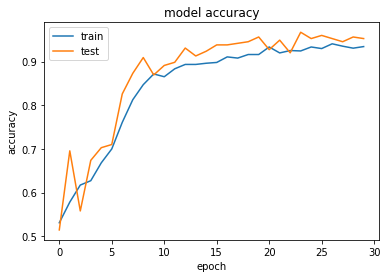

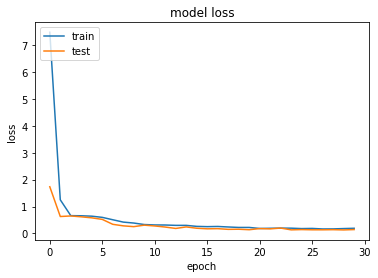

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
# list all data in training
print(training.history.keys())
# summarize training for accuracy
plt.plot(training.history['accuracy'])
plt.plot(training.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize traning for loss
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


[[0.]]
Prediction:  WithMask


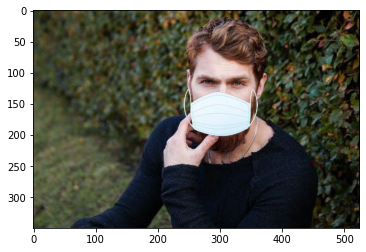

In [ ]:

from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.image as mpimg
img_pred = image.load_img("/content/test/test_with_mask/0-with-mask.jpg",target_size=(160,160))

img_pred=image.img_to_array(img_pred)
img_pred=np.expand_dims(img_pred, axis=0)

rslt = model.predict(img_pred)
print(rslt)
if rslt[0][0]==0:
    prediction ="WithMask"
else:
    prediction ="WithoutMask"
print('Prediction: ',prediction)

img=mpimg.imread('/content/test/test_with_mask/0-with-mask.jpg')
imgplot = plt.imshow(img)
plt.show()


[[1.]]
Prediction:  WithoutMask


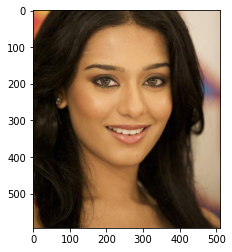

In [ ]:

img_pred = image.load_img("/content/test/test_without_mask/16.jpg",target_size=(160,160))

img_pred=image.img_to_array(img_pred)
img_pred=np.expand_dims(img_pred, axis=0)

rslt = model.predict(img_pred)
print(rslt)
if rslt[0][0]==0:
    prediction ="WithMask"
else:
    prediction ="WithoutMask"
print('Prediction: ',prediction)

img=mpimg.imread('/content/test/test_without_mask/16.jpg')
imgplot = plt.imshow(img)
plt.show()


In [ ]:

import json
from keras.models import model_from_json
from keras.models import load_model
from keras.preprocessing import image
import numpy as np

# serialize model to JSON
#model_json = model.to_json()
#model2 = Sequential()

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)



model.save_weights('model_weights.h5')
model.save('model.h5')
print("[INFO] Saved model to disk")

[INFO] Saved model to disk


## MobileNetV2

In [ ]:
'''pre_trained_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(150,150,3), alpha=1.0, include_top=False, weights='imagenet'
)'''
#WARNING:tensorflow:`input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
pre_trained_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(160,160,3), alpha=1.0, include_top=False, weights='imagenet'
)

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
pre_trained_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [ ]:
from keras.models import Model
image_size = 160
input_shape = (image_size, image_size, 3)

epochs = 20
batch_size = 16


for layer in pre_trained_model.layers[:52]:
    layer.trainable = False

for layer in pre_trained_model.layers[52:]:
    layer.trainable = True
    
last_layer = pre_trained_model.get_layer('out_relu')
last_output = last_layer.output
    
# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = Dense(1, activation='sigmoid')(x)

model2 = Model(pre_trained_model.input, x)



In [ ]:
initial_learning_rate = 0.002
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=5,
    decay_rate=0.96,
    staircase=True)   

optimizer = Adam(learning_rate=lr_schedule)
model2.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][0]']           

In [ ]:

from keras.callbacks import EarlyStopping,ModelCheckpoint
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, 
                              restore_best_weights=True,mode="max",patience = 9),
                ModelCheckpoint('best_model.h5',monitor="val_accuracy",verbose=1,
                                save_best_only=True,mode="max")]

In [ ]:
training1 = model2.fit(train_generator,
                   epochs=30,
                   validation_data=validation_generator,
                     #callbacks=[checkpointer]
                      )

Epoch 1/30
11/11 [==============================] - 66s 6s/step - loss: 4.4510 - accuracy: 0.8055 - val_loss: 2.6064 - val_accuracy: 0.7283
Epoch 2/30
11/11 [==============================] - 61s 5s/step - loss: 0.0756 - accuracy: 0.9682 - val_loss: 1.6824 - val_accuracy: 0.8333
Epoch 3/30
11/11 [==============================] - 64s 6s/step - loss: 0.0405 - accuracy: 0.9818 - val_loss: 1.7805 - val_accuracy: 0.8514
Epoch 4/30
11/11 [==============================] - 59s 5s/step - loss: 0.0144 - accuracy: 0.9955 - val_loss: 1.4791 - val_accuracy: 0.8514
Epoch 5/30
11/11 [==============================] - 59s 5s/step - loss: 0.0129 - accuracy: 0.9945 - val_loss: 1.3405 - val_accuracy: 0.8406
Epoch 6/30
11/11 [==============================] - 59s 5s/step - loss: 0.0083 - accuracy: 0.9973 - val_loss: 1.5121 - val_accuracy: 0.8587
Epoch 7/30
11/11 [==============================] - 63s 6s/step - loss: 0.0047 - accuracy: 0.9991 - val_loss: 1.6065 - val_accuracy: 0.8514
Epoch 8/30
11/11 [==

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


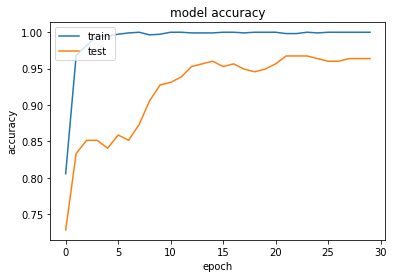

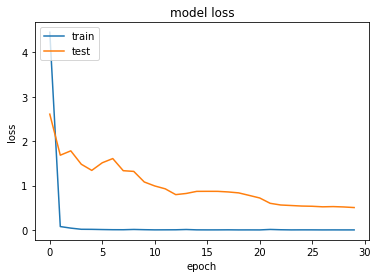

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
# list all data in training
print(training1.history.keys())
# summarize training for accuracy
plt.plot(training1.history['accuracy'])
plt.plot(training1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize traning for loss
plt.plot(training1.history['loss'])
plt.plot(training1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


[[0.]]
Prediction:  WithMask


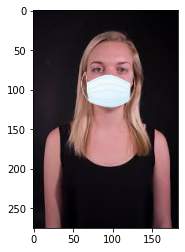

In [ ]:


img_pred = image.load_img("/content/test/test_with_mask/377-with-mask.jpg",target_size=(160,160))

img_pred=image.img_to_array(img_pred)
img_pred=np.expand_dims(img_pred, axis=0)

rslt = model.predict(img_pred)
print(rslt)
if rslt[0][0]==0:
    prediction ="WithMask"
else:
    prediction ="WithoutMask"
print('Prediction: ',prediction)

img=mpimg.imread('/content/test/test_with_mask/377-with-mask.jpg')
imgplot = plt.imshow(img)
plt.show()


[[1.]]
Prediction:  WithoutMask


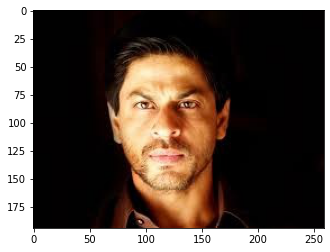

In [ ]:

img_pred = image.load_img("/content/test/test_without_mask/137.jpg",target_size=(160,160))

img_pred=image.img_to_array(img_pred)
img_pred=np.expand_dims(img_pred, axis=0)

rslt = model.predict(img_pred)
print(rslt)
if rslt[0][0]==0:
    prediction ="WithMask"
else:
    prediction ="WithoutMask"
print('Prediction: ',prediction)

img=mpimg.imread('/content/test/test_without_mask/137.jpg')
imgplot = plt.imshow(img)
plt.show()


In [ ]:

import json
from keras.models import model_from_json
from keras.models import load_model
from keras.preprocessing import image
import numpy as np

# serialize model to JSON
#model_json = model.to_json()
#model2 = Sequential()

model_json2 = model2.to_json()
with open("model2.json", "w") as json_file:
    json_file.write(model_json2)



model2.save_weights('model2_weights.h5')
model2.save('model2.h5')
print("[INFO] Saved model to disk")

[INFO] Saved model to disk


In [ ]:
cap = cv2.VideoCapture('People.avi')

CarCascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

if(cap.isOpened()== False): 
    print("Error opening video  file")

while(cap.isOpened()):

    success , frame = cap.read()
    
    if success:
    
        imgGray = cv2.cvtColor(frame , cv2.COLOR_BGR2HSV)

        cars = CarCascade.detectMultiScale(imgGray , 1.1 ,1)
    
        for (x,y,w,h) in cars:
            cv2.rectangle(frame,(x,y),(x+w,y+h),(0,0,0),2)
            rslt = model.predict(frame[x:x+w,y:y+h])
            print(rslt)
            if rslt[0][0]==0:
                prediction ="With Mask"
            else:
                prediction ="Without "

            font = cv2.FONT_HERSHEY_SIMPLEX
            org = (x, x+h)
            fontScale = 1
            color = (255, 0, 0)  
            thickness = 2
            frame = cv2.putText(frame,prediction,  org, font,fontScale, color, thickness, cv2.LINE_AA)

        cv2.imshow("Persons",frame)

        k = cv2.waitKey(5) & 0xFF
        if k == 27:
            break
    else:
        break
cap.release()
cv2.destroyAllWindows()